In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

In [36]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        space_values 
        time_index = sample_values[:, 0]
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

In [37]:
def pacient_explore(pt_number):
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    for arm in ['non_paretic', 'paretic']:
        data = non_paretic if arm == 'non_paretic' else paretic
        print(f'Pacient {pt_number} - {arm}')
        
        time_index = data['time_index']
        delta_t = np.diff(time_index).mean()
        N_samples = len(time_index)

        print(N_samples, 'samples')
        print('delta_t:', delta_t, 's')
        print('freq sampling:', 1/delta_t, 'Hz')        


    time_series_plot(paretic, non_paretic, pt_number)
    spectrogram_plot(paretic, non_paretic, pt_number)

def time_series_plot(paretic, non_paretic, pt_number):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))
    fig.suptitle(f'Pacient {pt_number}')
    
    for i_arm, arm in enumerate(['non_paretic', 'paretic']):
        data = non_paretic if arm == 'non_paretic' else paretic
        time_index = data['time_index']
        datetime_index = pd.to_datetime(time_index, unit='s')
        delta_t = np.diff(time_index).mean()
        
        for i_axis, axis in enumerate(['x', 'y', 'z', 'norm']):
            ax = axs[i_axis, i_arm]
            amplitude_acc = data['space_values'][:, i_axis]
            ax.plot(datetime_index, amplitude_acc)

            if axis == 'norm':
                seconds_cte = 1
                eps_acc = 0.02
                #indice_mov = np.abs(amplitude_acc - 1)
                #indice_mov = np.convolve(indice_mov, np.ones(seconds_cte*int(1/delta_t)), mode='same') / (seconds_cte*int(1/delta_t))
                # paint in red the constant acceleration zones
                #ax.fill_between(datetime_index, 0, 1, where=indice_mov < eps_acc, color='red', alpha=0.5)
                #plot indice_mov
                #ax.plot(datetime_index, indice_mov-eps_acc, color='red')

            ax.set_title(f'{arm} - {axis}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Acceleration')
            ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
            #ax.set_xlim(datetime_index[0], datetime_index[int(1/delta_t)*60*60*48])
            ax.grid()

        fig.tight_layout()

def spectrogram_plot(paretic, non_paretic, pt_number):
    fig, axs = plt.subplots(4, 2, figsize=(15, 15))
    fig.suptitle(f'Pacient {pt_number}')
    
    for i_arm, arm in enumerate(['non_paretic', 'paretic']):
        data = non_paretic if arm == 'non_paretic' else paretic
        time_index = data['time_index']
        delta_t = np.diff(time_index).mean()
        
        for i_axis, axis in enumerate(['x', 'y', 'z', 'norm']):
            ax = axs[i_axis, i_arm]
            ax.specgram(data['space_values'][:, i_axis], Fs=1/delta_t, NFFT=256, noverlap=128)
            ax.set_title(f'{arm} - {axis}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency')
            ax.grid()

        fig.tight_layout()


Pacient C1P08_20210810_1 - non_paretic
32761320 samples
delta_t: 0.019779277054804693 s
freq sampling: 50.5579651485333 Hz
Pacient C1P08_20210810_1 - paretic
32669520 samples
delta_t: 0.019834984750785472 s
freq sampling: 50.415970194300236 Hz


/Users/victor/Documents/GitHub/rearm-actimetry-exploring/.venv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


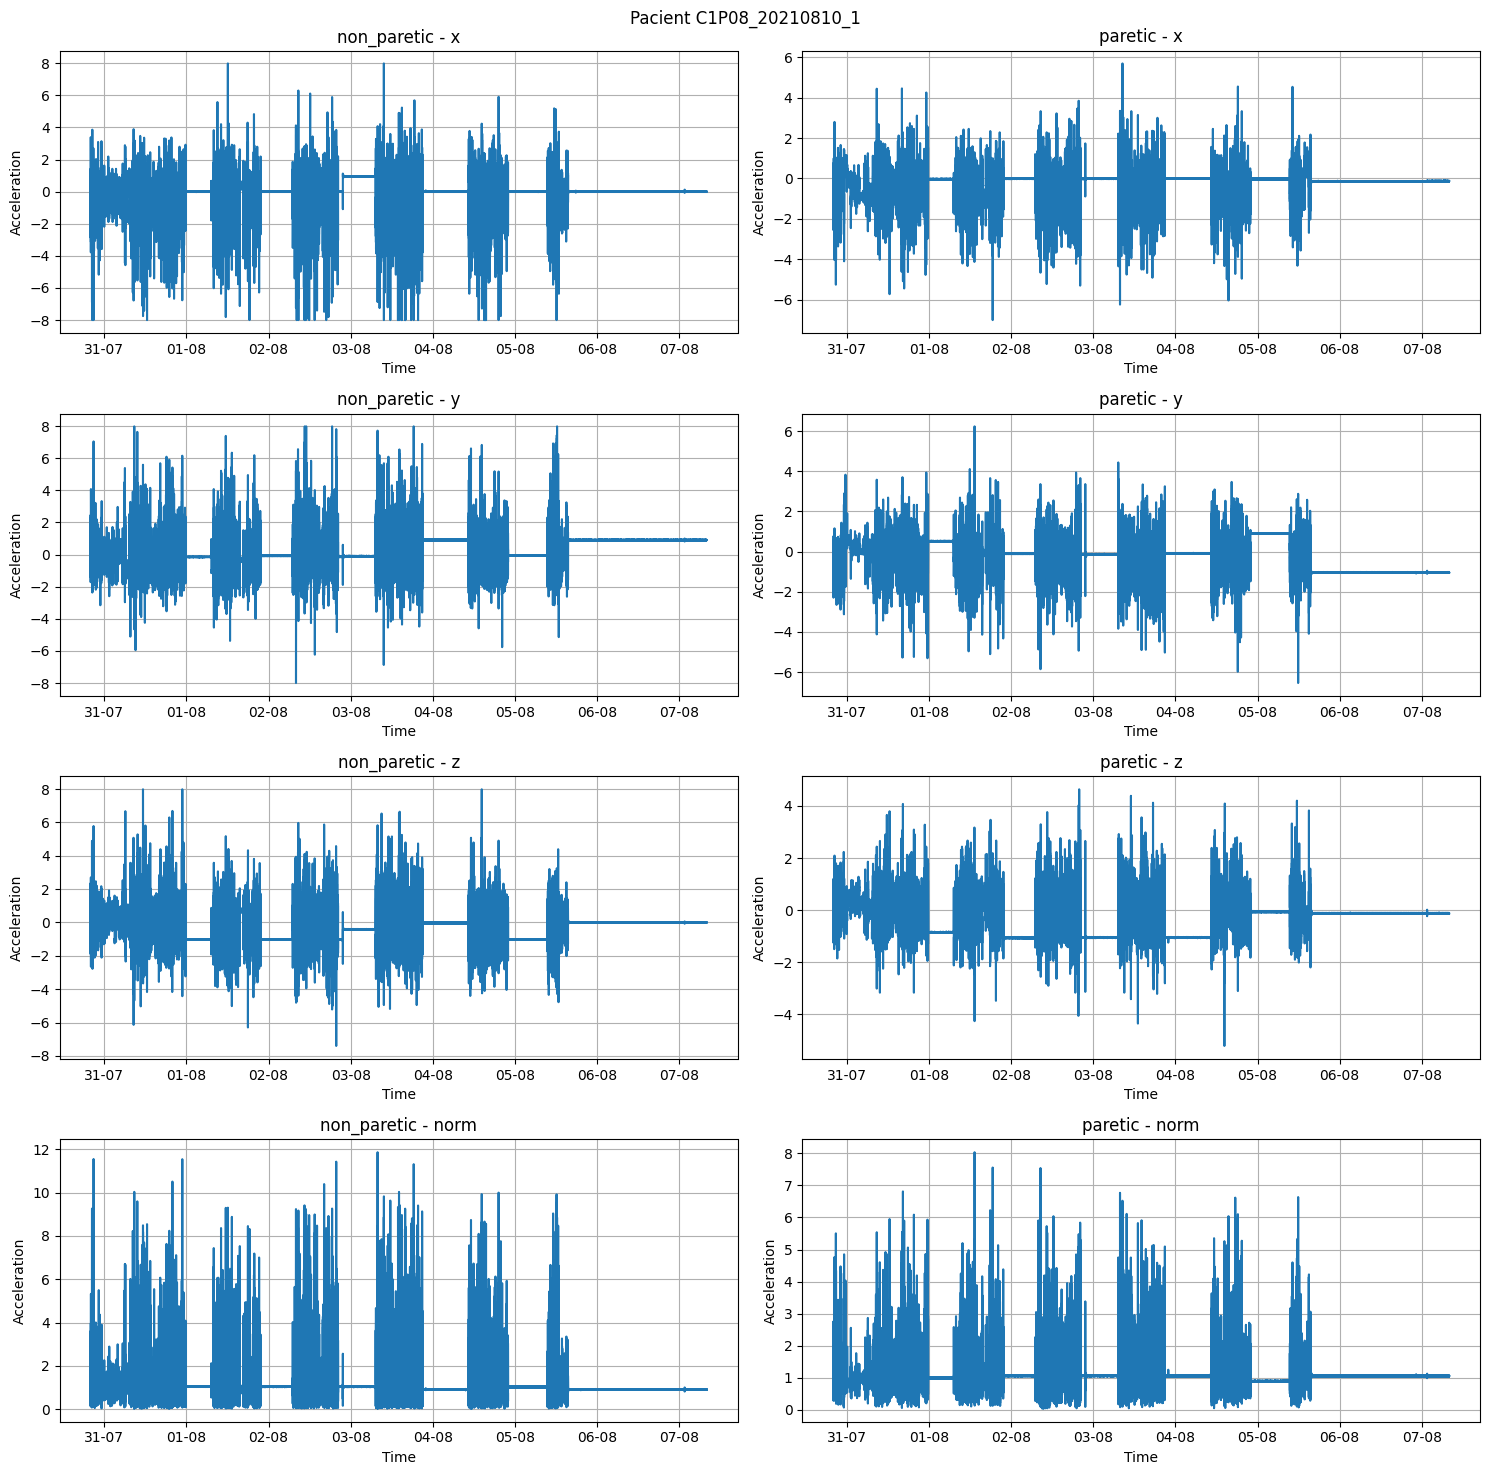

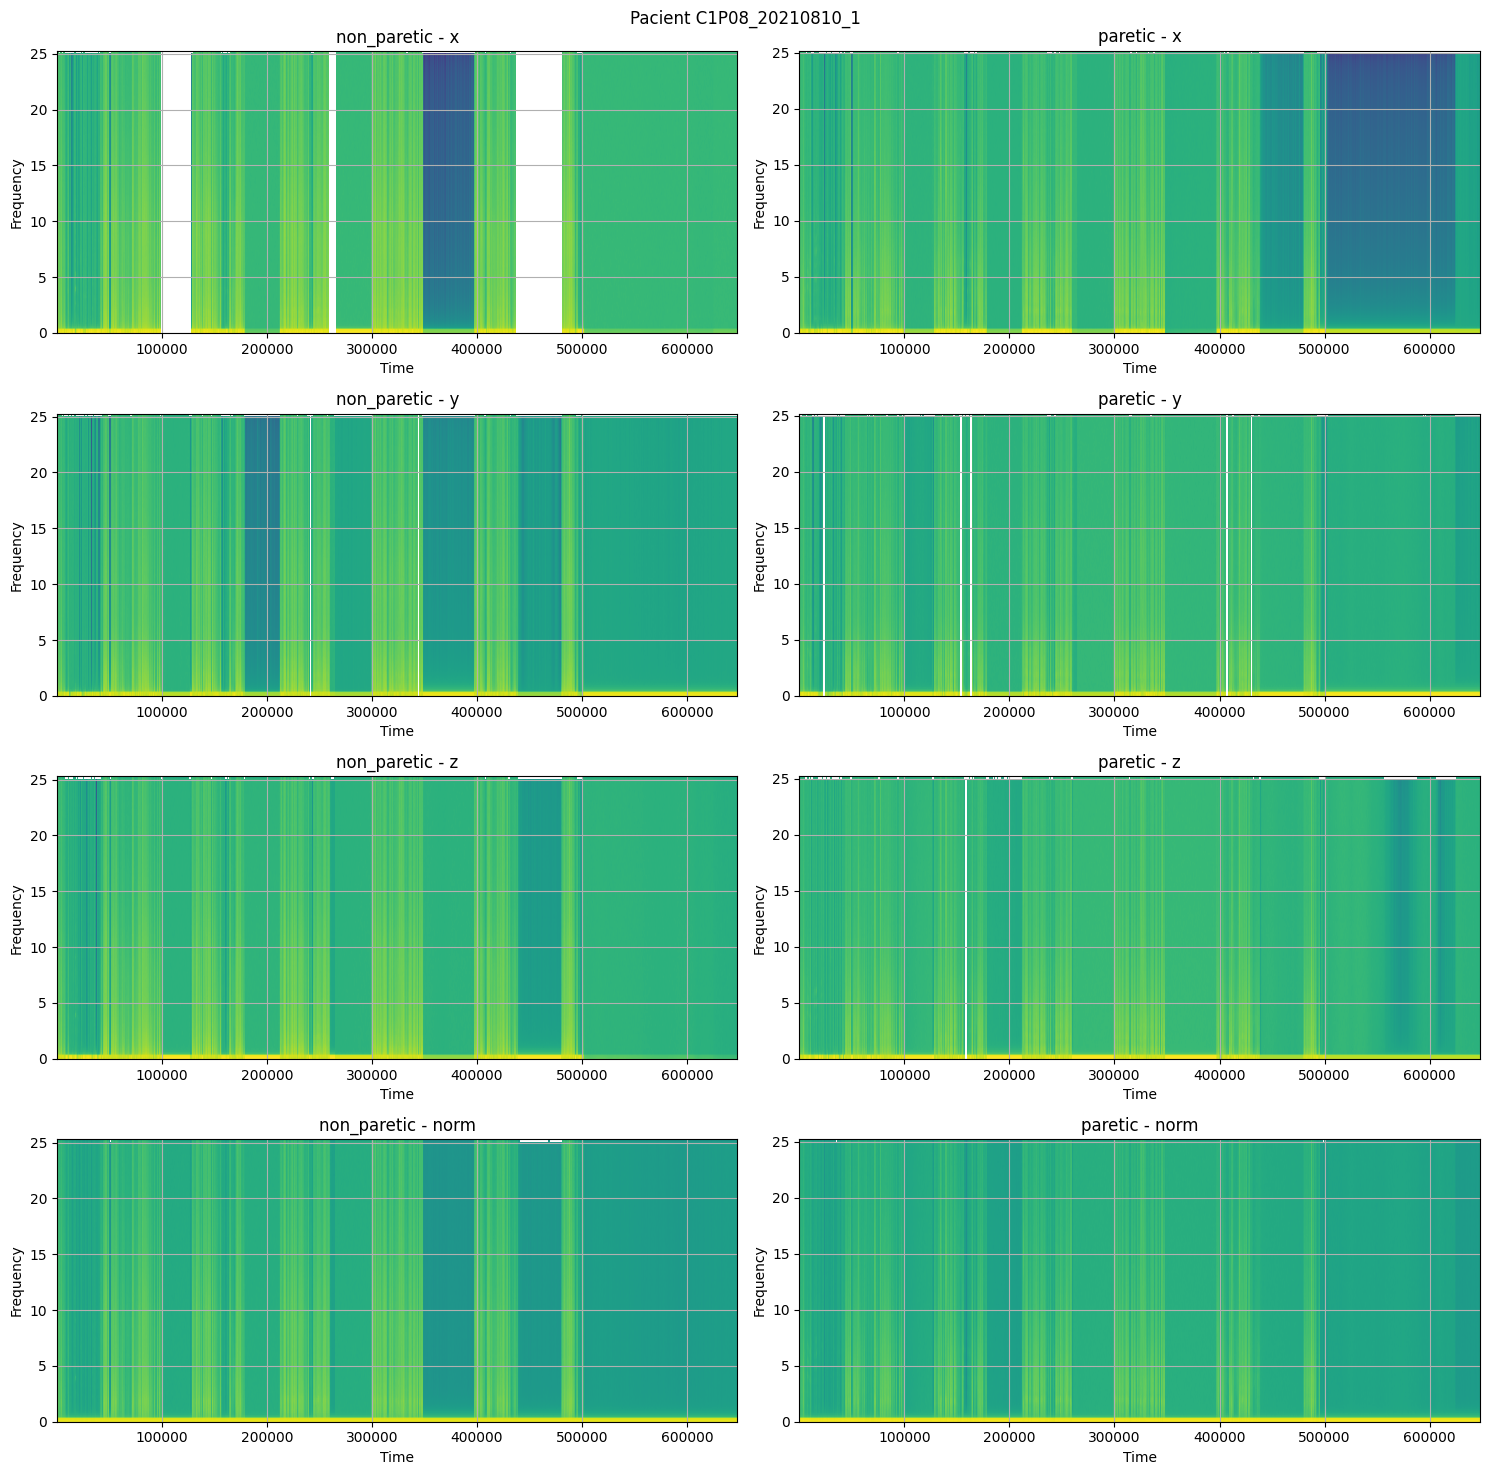

In [38]:
pacient_explore("C1P08_20210810_1")

In [34]:
import numpy as np
from scipy.stats import entropy

def extract_features(data_frame):
    """
    Extract features from sensor data frame.
    
    Parameters:
    data_frame: numpy.ndarray
        Raw sensor data with shape (n_samples, n_channels)
        
    Returns:
    dict: Dictionary containing all computed features
    """
    features = {}
    
    # DC Component
    features['dc_components'] = compute_dc_component(data_frame)
    
    # Energy
    features['energy'] = compute_energy(data_frame)
    
    # Entropy of spectrogram coefficients
    features['entropy'] = compute_spectral_entropy(data_frame)
    
    # Correlation coefficients
    features['correlation'] = compute_correlation_coefficients(data_frame)
    
    return features

def compute_dc_component(data_frame):
    """
    Compute DC component by averaging raw samples in each channel.
    Returns one feature per measurement channel.
    """
    return np.mean(data_frame, axis=0)

def compute_energy(data_frame):
    """
    Compute energy as sum of squared spectral coefficients.
    The DC component (mean) is excluded from the sum.
    Returns one feature per measurement channel.
    """
    # Remove DC component first
    dc_removed = data_frame - np.mean(data_frame, axis=0)
    
    # Compute FFT and get spectral coefficients
    spectral_coeffs = np.fft.fft(dc_removed, axis=0)
    
    # Sum squared magnitudes (excluding DC)
    energy = np.sum(np.abs(spectral_coeffs[1:]) ** 2, axis=0)
    
    return energy

def compute_spectral_entropy(data_frame):
    pass

def compute_correlation_coefficients(data_frame):
    pass